In [1]:
from torchvision.datasets import FashionMNIST as fm
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

# Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from torchvision import datasets
from torch.utils.data import sampler
batch_size = 20
lr = 3e-4
n_epoch = 100
class ChunkSampler(sampler.Sampler): 
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples
NUM_TRAIN = 50
train_loader = DataLoader(
    datasets.ImageFolder('/datasets/CelebA-stargan', transforms.Compose([
        transforms.CenterCrop((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # 用均值和方差归一化图片
    ])),
    batch_size=batch_size, shuffle=False,
    sampler=ChunkSampler(NUM_TRAIN, 0),
    num_workers=32,pin_memory=True)

In [3]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.gen_1 = nn.Sequential(
            nn.ConvTranspose2d(10, 1024, 3, 1, 0, bias = False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            
            nn.ConvTranspose2d(1024, 512, 5, 2, 2, 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.ConvTranspose2d(512,256,5,2,2, bias = False),
            nn.BatchNorm2d(256),
        )
        self.gen_2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, 2, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, 5, 3, 3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, 5, 2, 2, 1, bias = False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, 5, 1, 1, bias = False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.gen_3 = nn.Sequential(
            nn.ConvTranspose2d(16, 3, 5, 1, 1, bias = False),
            nn.Tanh()
        )
        self.upsample_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10,
                      out_channels = 256,
                      kernel_size = 15,
                      stride = 3,
                      padding = 3,
                      output_padding = 2),)
        self.upsample_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 256,
                      out_channels = 16,
                      kernel_size = 13,
                      stride = 13,
                      padding = 9,
                      output_padding = 1),)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
    def forward(self,x):
        out = x
        sample = self.upsample_1(x)
        x = self.gen_1(x) #(128, 1, 28, 28)
        x = x.clone() + sample
        x = self.relu(x)
        out = x
        sample = self.upsample_2(x)
        x = self.gen_2(x)
        x = x.clone() + sample
        x = self.relu(x)
        x = self.gen_3(x)
        return x
        

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dis_1 = nn.Sequential(
            nn.Conv2d(3, 16, 5, 1, 1, bias = False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(16, 32, 5, 1, 1,1, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(32, 64, 5, 2, 1, bias = False),
            nn.BatchNorm2d(64),
        )
        self.dis_2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, 1, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, 5, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, 5, 3, 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(512, 1024, 5, 3, 1, bias = False),
            nn.BatchNorm2d(1024),
        )
        self.dis_3 = nn.Sequential(
            nn.Conv2d(1024, 1, 3, 1, 0, bias = False),
            nn.Sigmoid()
        )#(batch_size , 1, 28, 28)
        self.downsample_1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,
                      out_channels = 64,
                      kernel_size = 8,
                      stride = 3,
                      padding = 30),)
        self.downsample_2 = nn.Sequential(
            nn.Conv2d(in_channels = 64,
                      out_channels = 1024,
                      kernel_size = 50,
                      stride = 5,
                      padding = 1),)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out = x
        sample = self.downsample_1(x)
        x = self.dis_1(x)
        x = x.clone() + sample
        x = self.relu(x)
        out = x
        sample = self.downsample_2(x)
        x = self.dis_2(x)
        x = x.clone() + sample
        x = self.relu(x)
        x = self.dis_3(x)
        return x

In [5]:
G = Generator().to(device)
D = Discriminator().to(device)

In [6]:
criterion = nn.BCELoss().to(device)
optimizer_g = torch.optim.Adam(G.parameters(), lr = lr)
optimizer_d = torch.optim.Adam(D.parameters(), lr = 0.1*lr)

In [7]:
losses_G = []
losses_D = []
for epoch in range(n_epoch):
    for i, (img, _) in enumerate(train_loader):
        real_label = 0.9*torch.ones(img.size(0),1,1,1).to(device)
        fake_label = 0.1*torch.ones(img.size(0),1,1,1).to(device)
       #########  AE  ###########
        img = img.to(device)
        
       ############ 训练判别器 ######### 
        z = torch.randn(img.size(0),10,1,1).to(device)
        real_img = D(img)
        loss_real = criterion(real_img, real_label)
        fake_img = G(z).detach()
        fake_img = D(fake_img)
        loss_fake = criterion(fake_img, fake_label)
        loss_D = loss_real + loss_fake
        
        losses_D.append(loss_D.item())
        optimizer_d.zero_grad()
        loss_D.backward()
        optimizer_d.step()
        ti = 0
        
#         for ti in range(2):
       ########### 训练生成器 ###########
        z = torch.randn(img.size(0),10,1,1).to(device)
        fake_img_2 = G(z)
        output = D(fake_img_2)
        loss_G = criterion(output, real_label)
        losses_G.append(loss_G.item())
        optimizer_g.zero_grad()
        loss_G.backward()
        optimizer_g.step()
    print('Epoch[{}/{}] D_loss:{:.4f}, G_loss:{:.4f} '.format(epoch+1, n_epoch,loss_D.item(), loss_G.item()))
torch.save(G, './G.pth')
torch.save(D, './D.pth')

Epoch[1/100] D_loss:1.0071, G_loss:10.0578 
Epoch[2/100] D_loss:3.4910, G_loss:3.9416 
Epoch[3/100] D_loss:0.8856, G_loss:5.4518 
Epoch[4/100] D_loss:0.9211, G_loss:6.1506 
Epoch[5/100] D_loss:0.8642, G_loss:4.1181 
Epoch[6/100] D_loss:0.6947, G_loss:3.5309 
Epoch[7/100] D_loss:0.6970, G_loss:4.3814 
Epoch[8/100] D_loss:0.6810, G_loss:3.8184 
Epoch[9/100] D_loss:0.6765, G_loss:3.9654 
Epoch[10/100] D_loss:0.7227, G_loss:4.1099 
Epoch[11/100] D_loss:0.6788, G_loss:3.9576 
Epoch[12/100] D_loss:0.6813, G_loss:3.6216 
Epoch[13/100] D_loss:0.6626, G_loss:4.0398 
Epoch[14/100] D_loss:0.6664, G_loss:4.6176 
Epoch[15/100] D_loss:0.8133, G_loss:5.0217 
Epoch[16/100] D_loss:0.6969, G_loss:2.6837 
Epoch[17/100] D_loss:0.7748, G_loss:3.8260 
Epoch[18/100] D_loss:0.6958, G_loss:4.6502 
Epoch[19/100] D_loss:0.6955, G_loss:2.7341 
Epoch[20/100] D_loss:0.7141, G_loss:3.8888 
Epoch[21/100] D_loss:0.6914, G_loss:4.0952 
Epoch[22/100] D_loss:0.7293, G_loss:3.0608 
Epoch[23/100] D_loss:0.6847, G_loss:3.29

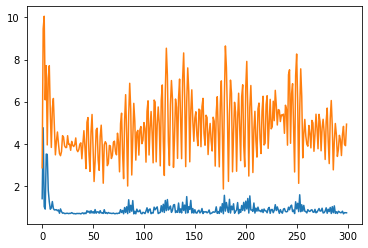

In [8]:
import matplotlib.pyplot as plt
plt.plot(losses_D, '-')
plt.plot(losses_G, '-')
plt.show()